Iniciando o processo de extração e consolidação...

Baixando dados de 2017...
Download concluído.
Lendo o arquivo 'inf_mensal_fii_geral_2017.csv'...
Dados de 2017 lidos e padronizados com sucesso (3716 linhas).

Baixando dados de 2018...
Download concluído.
Lendo o arquivo 'inf_mensal_fii_geral_2018.csv'...
Dados de 2018 lidos e padronizados com sucesso (4287 linhas).

Baixando dados de 2019...
Download concluído.
Lendo o arquivo 'inf_mensal_fii_geral_2019.csv'...
Dados de 2019 lidos e padronizados com sucesso (4958 linhas).

Baixando dados de 2020...
Download concluído.
Lendo o arquivo 'inf_mensal_fii_geral_2020.csv'...
Dados de 2020 lidos e padronizados com sucesso (6079 linhas).

Baixando dados de 2021...
Download concluído.
Lendo o arquivo 'inf_mensal_fii_geral_2021.csv'...
Dados de 2021 lidos e padronizados com sucesso (7567 linhas).

Baixando dados de 2022...
Download concluído.
Lendo o arquivo 'inf_mensal_fii_geral_2022.csv'...
Dados de 2022 lidos e padronizados com sucesso (898

/tmp/ipython-input-953094075.py:90: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fundos_por_mes = df_geral_consolidado.groupby(pd.Grouper(key='data_referencia_unificada', freq='M'))['cnpj_unificado'].nunique().reset_index()


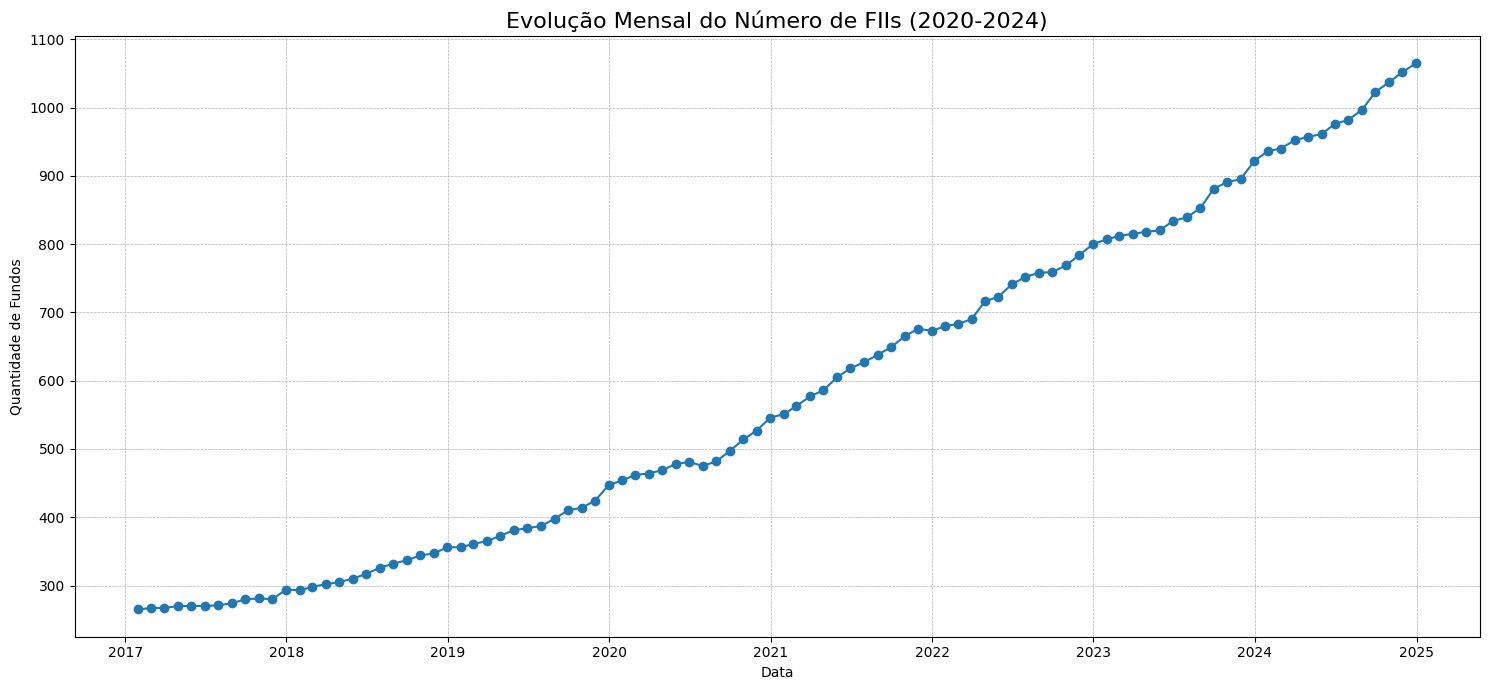


Gerando análise por Segmento de Atuação...

Verificação para Jan/2020:
Soma dos segmentos: 454
Total de fundos reportado: 454


/tmp/ipython-input-953094075.py:104: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_geral_consolidado['segmento_unificado'].fillna('Indefinido', inplace=True)
/tmp/ipython-input-953094075.py:108: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  [pd.Grouper(key='data_referencia_unificada', freq='M'), 'segmento_unificado']


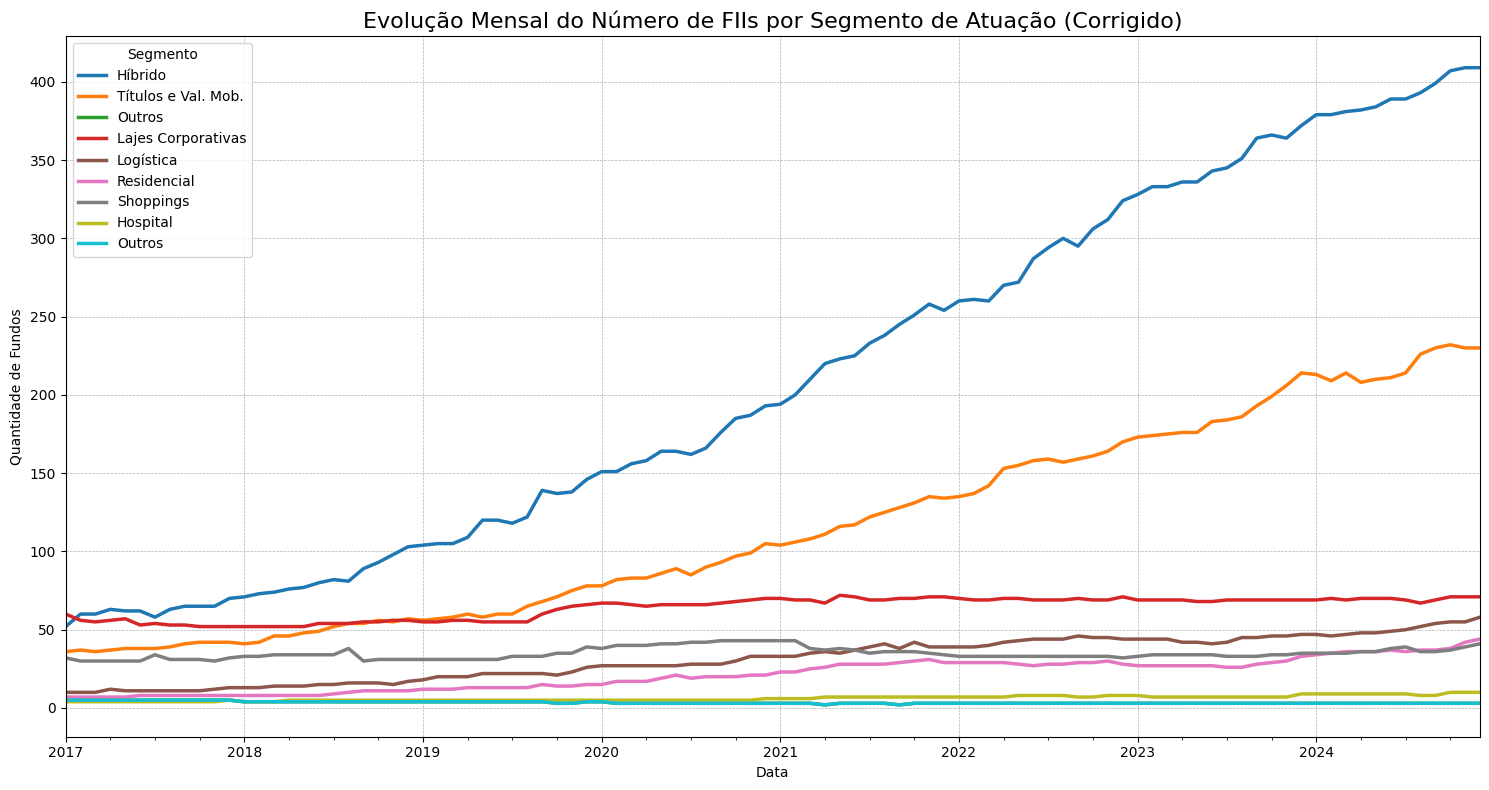


Gerando análise por Público Alvo...


/tmp/ipython-input-953094075.py:138: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  publico_evolucao = df_geral_consolidado.groupby([pd.Grouper(key='data_referencia_unificada', freq='M'), 'publico_alvo_unificado'])['cnpj_unificado'].nunique().unstack().fillna(0)


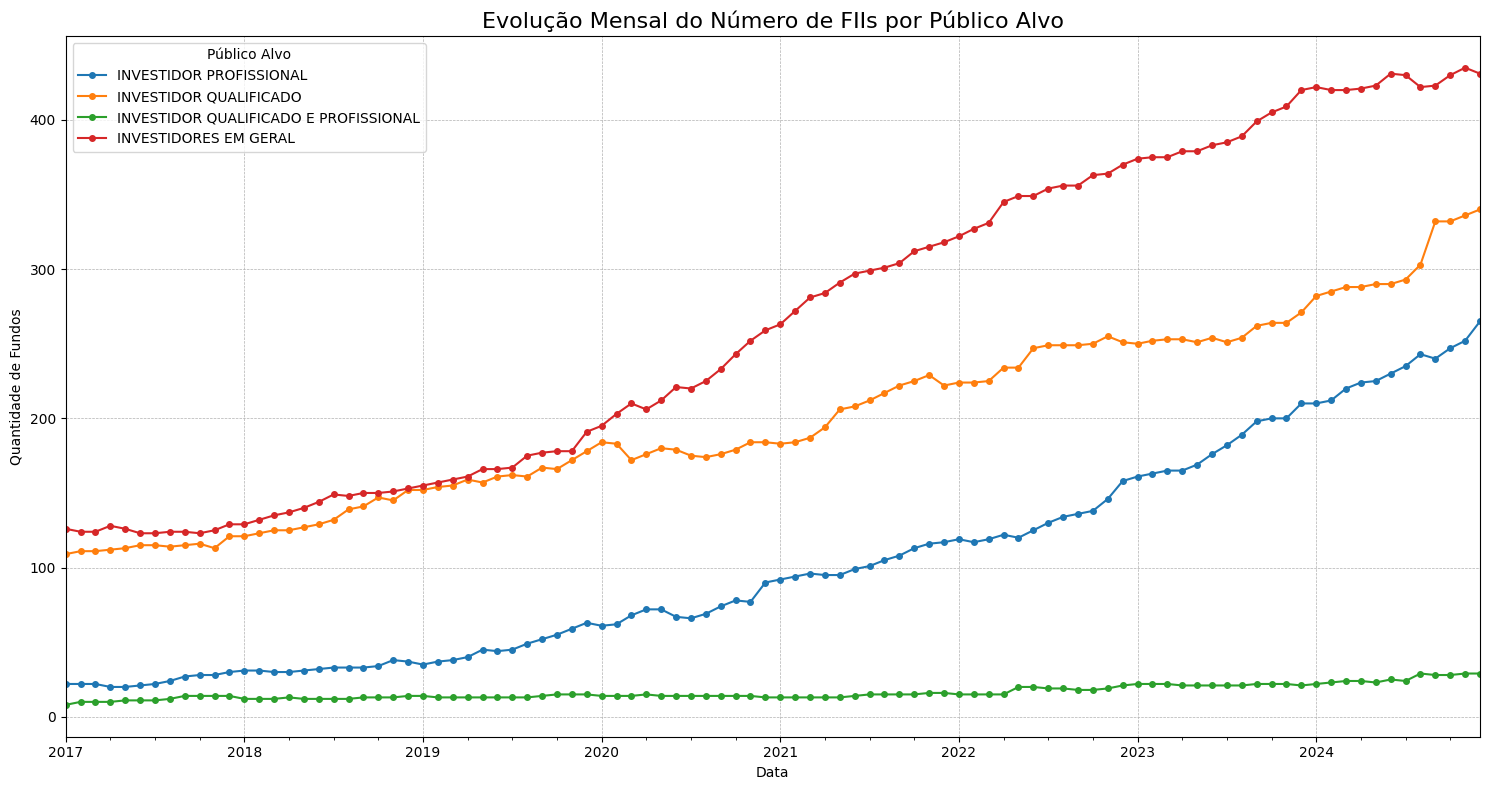

In [ ]:
import io
import zipfile
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def read_csv_robusto(filelike):
    """Lê um arquivo CSV de um objeto 'file-like', testando diferentes separadores e encodings."""
    filelike.seek(0)
    for enc in ("latin-1", "utf-8", "cp1252"):
        for sep in (";", ","):
            try:
                filelike.seek(0)
                df = pd.read_csv(filelike, sep=sep, encoding=enc, dtype=str, low_memory=False)
                if df.shape[1] > 5:
                    return df
            except Exception:
                continue
    raise ValueError("Não foi possível ler o CSV com os encodings/separadores testados.")

# --- 1. DOWNLOAD E CONSOLIDAÇÃO COM LÓGICA DE UNIFICAÇÃO ROBUSTA ---
lista_dfs_geral = []
anos = range(2017, 2025) # 2020 a 2024

print("Iniciando o processo de extração e consolidação...")

for ano in anos:
    url = f"https://dados.cvm.gov.br/dados/FII/DOC/INF_MENSAL/DADOS/inf_mensal_fii_{ano}.zip"

    try:
        print(f"\nBaixando dados de {ano}...")
        response = requests.get(url, timeout=180)
        response.raise_for_status()
        print("Download concluído.")

        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            nome_arquivo_csv = next((nome for nome in z.namelist() if 'geral' in nome.lower() and nome.lower().endswith('.csv')), None)
            if nome_arquivo_csv is None:
                raise FileNotFoundError(f"Nenhum arquivo 'geral' encontrado no ZIP de {ano}.")

            print(f"Lendo o arquivo '{nome_arquivo_csv}'...")
            with z.open(nome_arquivo_csv) as f:
                buffer = io.BytesIO(f.read())
                df_ano = read_csv_robusto(buffer)

                # --- LÓGICA DE UNIFICAÇÃO CORRIGIDA ---
                # 1. Padroniza TODOS os nomes de colunas para minúsculo
                df_ano.columns = [col.lower() for col in df_ano.columns]

                # 2. Unifica a coluna de Data de forma segura
                df_ano['data_referencia_unificada'] = df_ano['dt_refer'] if 'dt_refer' in df_ano.columns else df_ano.get('data_referencia')

                # 3. Unifica a coluna de CNPJ de forma segura
                if 'cnpj_fundo' in df_ano.columns and 'cnpj_fundo_classe' in df_ano.columns:
                    df_ano['cnpj_unificado'] = df_ano['cnpj_fundo'].fillna(df_ano['cnpj_fundo_classe'])
                elif 'cnpj_fundo' in df_ano.columns:
                    df_ano['cnpj_unificado'] = df_ano['cnpj_fundo']
                elif 'cnpj_fundo_classe' in df_ano.columns:
                    df_ano['cnpj_unificado'] = df_ano['cnpj_fundo_classe']
                else:
                    df_ano['cnpj_unificado'] = None # Caso nenhuma coluna seja encontrada

                # 4. Unifica a coluna de Segmento
                df_ano['segmento_unificado'] = df_ano['segmento_atuacao_fundo'] if 'segmento_atuacao_fundo' in df_ano.columns else df_ano.get('segmento_atuacao')

                # 5. Unifica a coluna de Público Alvo
                df_ano['publico_alvo_unificado'] = df_ano['publico_alvo_fundo'] if 'publico_alvo_fundo' in df_ano.columns else df_ano.get('publico_alvo')

                lista_dfs_geral.append(df_ano)
                print(f"Dados de {ano} lidos e padronizados com sucesso ({len(df_ano)} linhas).")

    except Exception as e:
        print(f"ERRO ao processar o ano {ano}: {e}")

# --- 2. PREPARAÇÃO FINAL E ANÁLISES ---
if not lista_dfs_geral:
    print("\nNenhum dado foi baixado. O processo não pôde ser concluído.")
else:
    print("\nConsolidando todos os anos em uma única base de dados...")
    df_geral_consolidado = pd.concat(lista_dfs_geral, ignore_index=True)

    print("Limpando e preparando a base de dados final...")
    df_geral_consolidado['data_referencia_unificada'] = pd.to_datetime(df_geral_consolidado['data_referencia_unificada'])
    df_geral_consolidado.dropna(subset=['cnpj_unificado', 'segmento_unificado', 'publico_alvo_unificado'], inplace=True)


    # --- Análise 1: Evolução do Número Total de Fundos ---
    print("\nCalculando a evolução total de fundos...")
    fundos_por_mes = df_geral_consolidado.groupby(pd.Grouper(key='data_referencia_unificada', freq='M'))['cnpj_unificado'].nunique().reset_index()
    fundos_por_mes.rename(columns={'cnpj_unificado': 'Quantidade_Fundos', 'data_referencia_unificada':'Data'}, inplace=True)

    plt.figure(figsize=(15, 7))
    plt.plot(fundos_por_mes['Data'], fundos_por_mes['Quantidade_Fundos'], marker='o', linestyle='-')
    plt.title('Evolução Mensal do Número de FIIs (2020-2024)', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Quantidade de Fundos')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # --- Análise 2: Evolução por Segmento de Atuação ---
    print("\nGerando análise por Segmento de Atuação...")
    df_geral_consolidado['segmento_unificado'].fillna('Indefinido', inplace=True)

# Agrupa os dados, agora incluindo a nova categoria 'Indefinido'
    segmento_evolucao = df_geral_consolidado.groupby(
        [pd.Grouper(key='data_referencia_unificada', freq='M'), 'segmento_unificado']
    )['cnpj_unificado'].nunique().unstack().fillna(0)

    # Opcional: Verificar a soma para um mês específico (ex: Janeiro de 2020)
    print("\nVerificação para Jan/2020:")
    print("Soma dos segmentos:", segmento_evolucao.loc['2020-01-31'].sum())
    print("Total de fundos reportado:", fundos_por_mes[fundos_por_mes['Data'] == '2020-01-31']['Quantidade_Fundos'].iloc[0])


    # A lógica para plotar o gráfico continua a mesma
    maiores_segmentos = segmento_evolucao.iloc[-1].sort_values(ascending=False).head(8).index.tolist()
    if 'Indefinido' not in maiores_segmentos and 'Indefinido' in segmento_evolucao.columns:
        maiores_segmentos.append('Indefinido')


    segmento_evolucao['Outros'] = segmento_evolucao.drop(columns=maiores_segmentos, errors='ignore').sum(axis=1)
    df_plot_segmento = segmento_evolucao[maiores_segmentos + ['Outros']]


    df_plot_segmento.plot(kind='line', figsize=(15, 8), colormap='tab10', linewidth=2.5)
    plt.title('Evolução Mensal do Número de FIIs por Segmento de Atuação (Corrigido)', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Quantidade de Fundos')
    plt.legend(title='Segmento')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    # --- Análise 3: Evolução por Público Alvo ---
    print("\nGerando análise por Público Alvo...")
    publico_evolucao = df_geral_consolidado.groupby([pd.Grouper(key='data_referencia_unificada', freq='M'), 'publico_alvo_unificado'])['cnpj_unificado'].nunique().unstack().fillna(0)

    publico_evolucao.plot(kind='line', figsize=(15, 8), marker='o', linestyle='-', markersize=4)
    plt.title('Evolução Mensal do Número de FIIs por Público Alvo', fontsize=16)
    plt.xlabel('Data')
    plt.ylabel('Quantidade de Fundos')
    plt.legend(title='Público Alvo')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [ ]:
segmento_evolucao = df_geral_consolidado.groupby(
        [pd.Grouper(key='data_referencia_unificada', freq='M'), 'segmento_unificado']
    )['cnpj_unificado'].nunique().unstack().fillna(0)

    # Opcional: Verificar a soma para um mês específico (ex: Janeiro de 2020)


/tmp/ipython-input-2209062459.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  [pd.Grouper(key='data_referencia_unificada', freq='M'), 'segmento_unificado']


In [ ]:
segmento_evolucao

segmento_unificado,Hospital,Hotel,Híbrido,Lajes Corporativas,Logística,Outros,Residencial,Shoppings,Títulos e Val. Mob.
data_referencia_unificada,,,,,,,,,
2017-01-31,4,5,52,60,10,59,7,32,36
2017-02-28,4,5,60,56,10,58,7,30,37
2017-03-31,4,5,60,55,10,60,7,30,36
2017-04-30,4,5,63,56,12,56,7,30,37
2017-05-31,4,5,62,57,11,56,7,30,38
...,...,...,...,...,...,...,...,...,...
2024-08-31,8,3,393,67,52,175,37,36,226
2024-09-30,8,3,399,69,54,187,37,36,230
2024-10-31,10,3,407,71,55,184,38,37,232


In [ ]:
fundos_por_mes

,Data,Quantidade_Fundos
0,2017-01-31,265
1,2017-02-28,267
2,2017-03-31,267
3,2017-04-30,270
4,2017-05-31,270
...,...,...
91,2024-08-31,997
92,2024-09-30,1023
93,2024-10-31,1037
94,2024-11-30,1052


Iniciando extração e consolidação (Geral + Complemento)...

Processando 2020...
Dados de 2020 lidos e juntados com sucesso.

Processando 2021...
Dados de 2021 lidos e juntados com sucesso.

Processando 2022...
Dados de 2022 lidos e juntados com sucesso.

Processando 2023...
Dados de 2023 lidos e juntados com sucesso.

Processando 2024...
Dados de 2024 lidos e juntados com sucesso.

Consolidando todos os anos...
Limpando e preparando a base de dados final...
Total de registros antes do filtro de versão: 44840
Total de registros após o filtro de versão: 44840

Gerando gráfico: Evolução do PL Total...


/tmp/ipython-input-85391550.py:99: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pl_por_mes = df_final_unico.groupby(pd.Grouper(key='data_referencia', freq='M'))['patrimonio_liquido'].sum().reset_index()


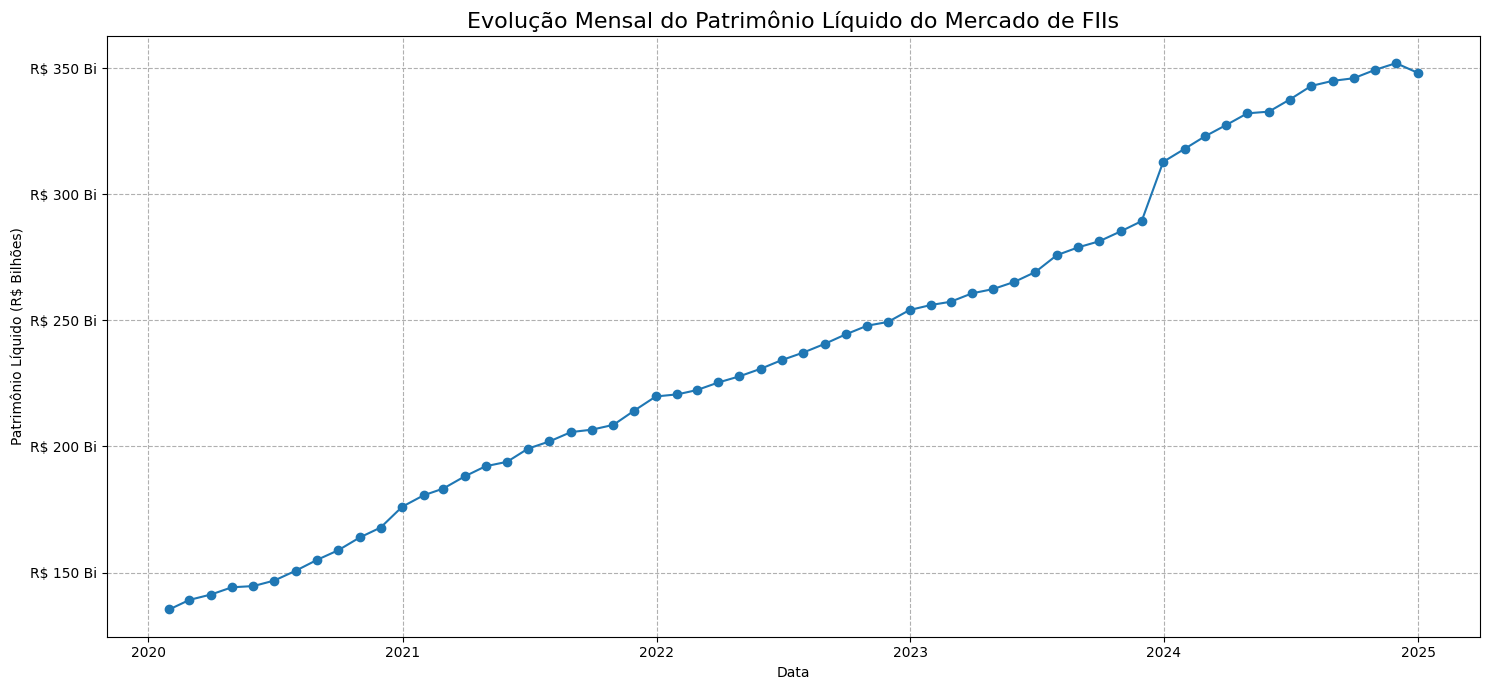

Gerando gráfico: Evolução do PL por Segmento...


/tmp/ipython-input-85391550.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pl_segmento = df_final_unico.groupby([pd.Grouper(key='data_referencia', freq='M'), 'segmento_atuacao'])['patrimonio_liquido'].sum().unstack().fillna(0)


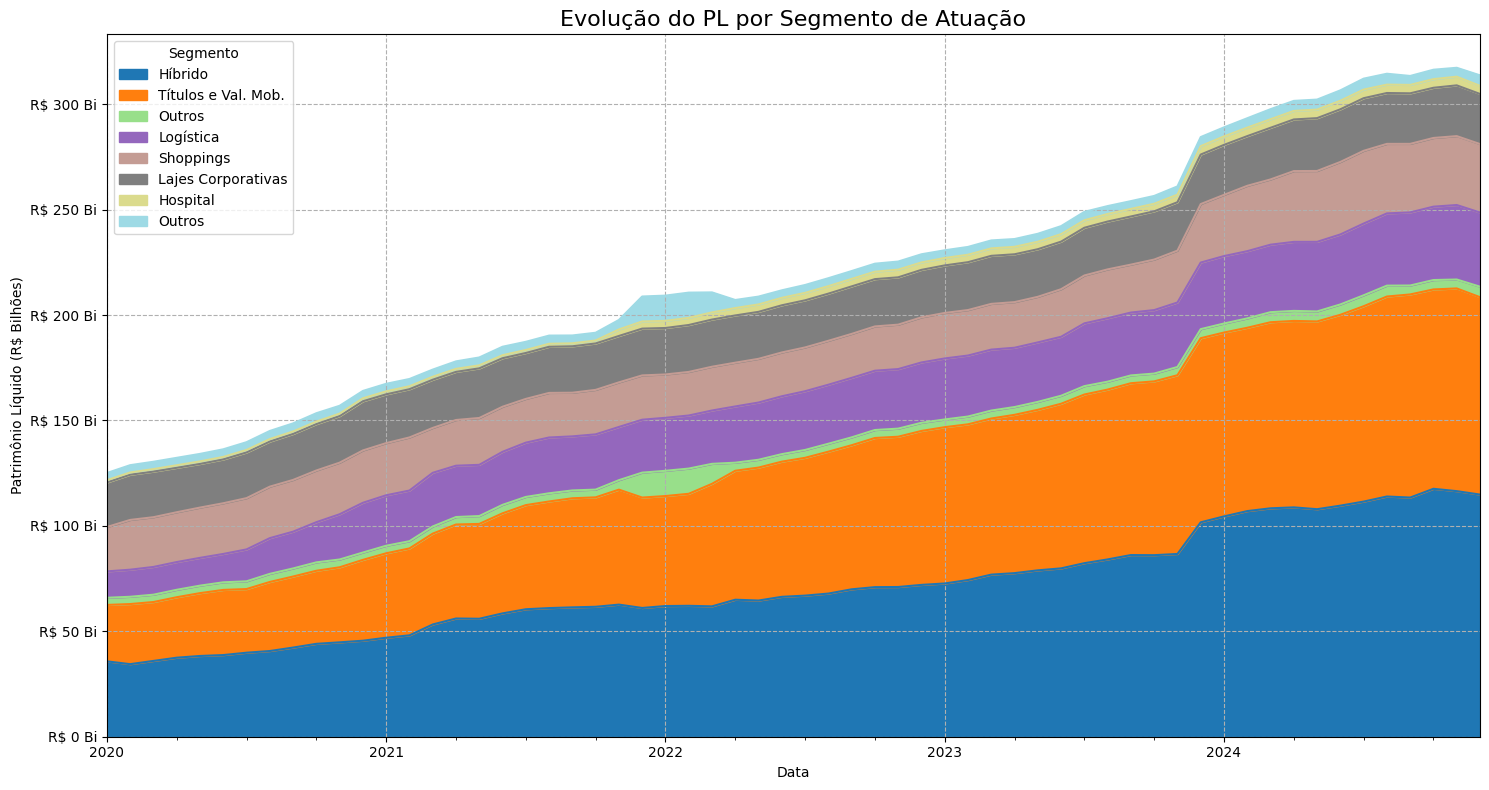

Gerando gráfico: Evolução do PL por Público Alvo...


/tmp/ipython-input-85391550.py:122: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  pl_publico = df_final_unico.groupby([pd.Grouper(key='data_referencia', freq='M'), 'publico_alvo'])['patrimonio_liquido'].sum().unstack().fillna(0)


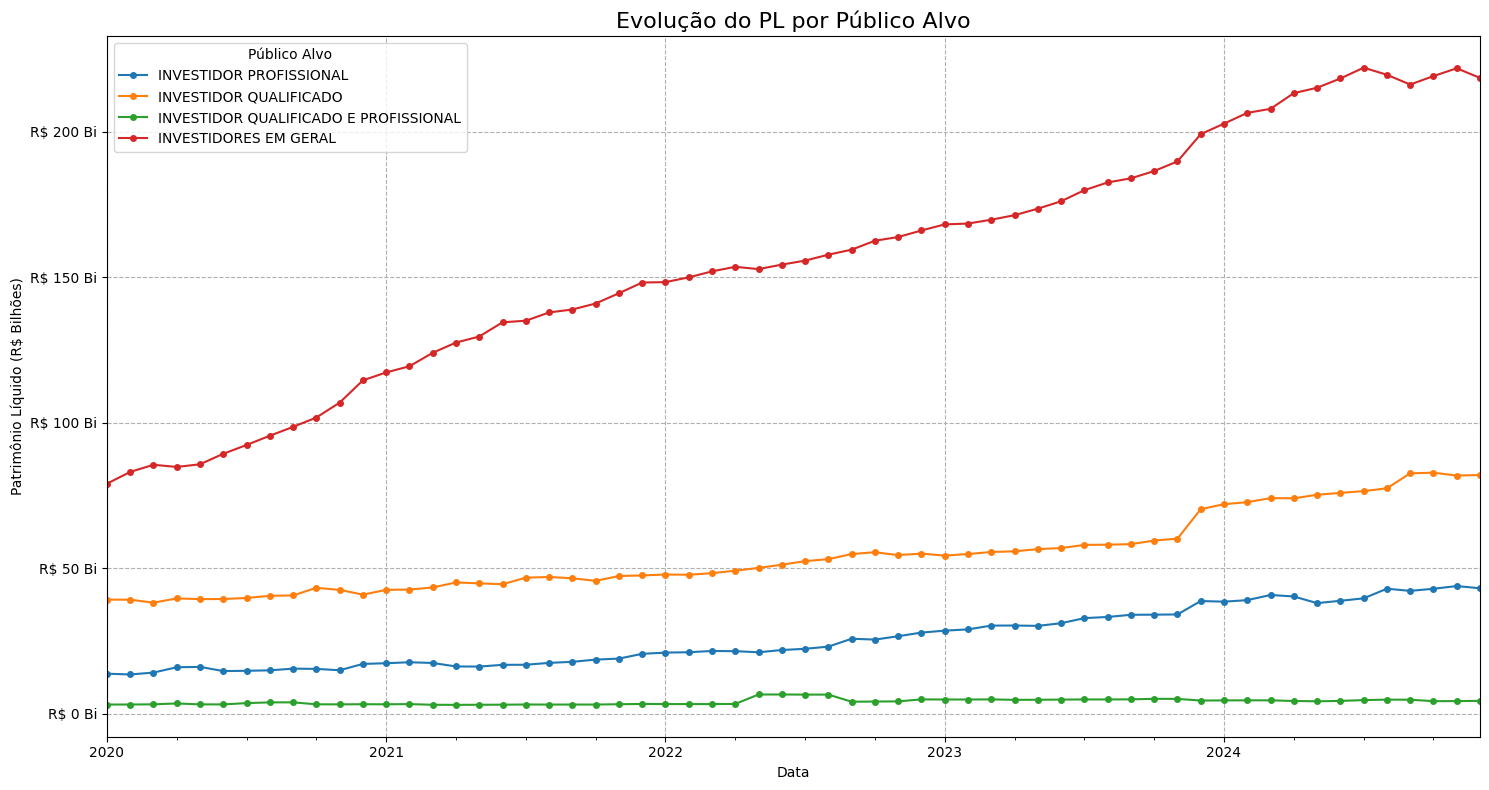

In [ ]:
import io
import zipfile
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

def read_csv_robusto(filelike):
    """Lê um CSV de forma robusta, testando diferentes separadores e encodings."""
    filelike.seek(0)
    for enc in ("latin-1", "utf-8", "cp1252"):
        for sep in (";", ","):
            try:
                filelike.seek(0)
                df = pd.read_csv(filelike, sep=sep, encoding=enc, dtype=str, low_memory=False)
                if df.shape[1] > 5: return df
            except Exception: continue
    raise ValueError("Não foi possível ler o CSV.")

# --- 1. DOWNLOAD E CONSOLIDAÇÃO USANDO A LÓGICA CORRETA PARA AMBOS OS ARQUIVOS ---
lista_dfs_anuais = []
anos = range(2020, 2025)

print("Iniciando extração e consolidação (Geral + Complemento)...")
for ano in anos:
    url = f"https://dados.cvm.gov.br/dados/FII/DOC/INF_MENSAL/DADOS/inf_mensal_fii_{ano}.zip"
    try:
        print(f"\nProcessando {ano}...")
        response = requests.get(url, timeout=180)
        response.raise_for_status()

        with zipfile.ZipFile(io.BytesIO(response.content)) as z:
            # --- Processa o arquivo GERAL ---
            nome_geral = next((n for n in z.namelist() if 'geral' in n.lower() and n.endswith('.csv')), None)
            with z.open(nome_geral) as f:
                df_geral = read_csv_robusto(io.BytesIO(f.read()))
                df_geral.columns = [c.lower() for c in df_geral.columns]

                # Unificação de colunas para GERAL (lógica que funcionou)
                df_geral['data_referencia'] = df_geral['dt_refer'] if 'dt_refer' in df_geral.columns else df_geral.get('data_referencia')
                if 'cnpj_fundo' in df_geral.columns and 'cnpj_fundo_classe' in df_geral.columns:
                    df_geral['cnpj_unificado'] = df_geral['cnpj_fundo'].fillna(df_geral['cnpj_fundo_classe'])
                elif 'cnpj_fundo' in df_geral.columns:
                    df_geral['cnpj_unificado'] = df_geral['cnpj_fundo']
                elif 'cnpj_fundo_classe' in df_geral.columns:
                    df_geral['cnpj_unificado'] = df_geral['cnpj_fundo_classe']

                df_geral['segmento_atuacao'] = df_geral['segmento_atuacao_fundo'] if 'segmento_atuacao_fundo' in df_geral.columns else df_geral.get('segmento_atuacao')
                df_geral['publico_alvo'] = df_geral['publico_alvo_fundo'] if 'publico_alvo_fundo' in df_geral.columns else df_geral.get('publico_alvo')

            # --- Processa o arquivo COMPLEMENTO ---
            nome_comp = next((n for n in z.namelist() if 'complemento' in n.lower() and n.endswith('.csv')), None)
            with z.open(nome_comp) as f:
                df_comp = read_csv_robusto(io.BytesIO(f.read()))
                df_comp.columns = [c.lower() for c in df_comp.columns]

                # Unificação de colunas para COMPLEMENTO (usando a mesma lógica robusta)
                df_comp['data_referencia'] = df_comp['dt_refer'] if 'dt_refer' in df_comp.columns else df_comp.get('data_referencia')
                if 'cnpj_fundo' in df_comp.columns and 'cnpj_fundo_classe' in df_comp.columns: # Checa ambos, mesmo que _classe não seja esperado
                    df_comp['cnpj_unificado'] = df_comp['cnpj_fundo'].fillna(df_comp['cnpj_fundo_classe'])
                elif 'cnpj_fundo' in df_comp.columns:
                    df_comp['cnpj_unificado'] = df_comp['cnpj_fundo']
                elif 'cnpj_fundo_classe' in df_comp.columns:
                    df_comp['cnpj_unificado'] = df_comp['cnpj_fundo_classe']

            # Junta os dados do ano
            df_anual_merged = pd.merge(
                df_geral[['cnpj_unificado', 'data_referencia', 'versao', 'segmento_atuacao', 'publico_alvo']],
                df_comp[['cnpj_unificado', 'data_referencia', 'versao', 'patrimonio_liquido']],
                on=['cnpj_unificado', 'data_referencia', 'versao']
            )
            lista_dfs_anuais.append(df_anual_merged)
            print(f"Dados de {ano} lidos e juntados com sucesso.")
    except Exception as e:
        print(f"ERRO ao processar o ano {ano}: {e}")

# --- 2. CONSOLIDAÇÃO, LIMPEZA E FILTRO DE VERSÃO ---
if lista_dfs_anuais:
    print("\nConsolidando todos os anos...")
    df_final = pd.concat(lista_dfs_anuais, ignore_index=True)

    print("Limpando e preparando a base de dados final...")
    df_final['data_referencia'] = pd.to_datetime(df_final['data_referencia'])
    df_final['versao'] = pd.to_numeric(df_final['versao'], errors='coerce')
    df_final['patrimonio_liquido'] = pd.to_numeric(df_final['patrimonio_liquido'].str.replace(',', '.'), errors='coerce')
    df_final.dropna(subset=['cnpj_unificado', 'patrimonio_liquido', 'versao'], inplace=True)

    # --- FILTRAGEM DA VERSÃO MAIS RECENTE ---
    print(f"Total de registros antes do filtro de versão: {len(df_final)}")
    df_final.sort_values(['cnpj_unificado', 'data_referencia', 'versao'], ascending=[True, True, False], inplace=True)
    df_final_unico = df_final.drop_duplicates(subset=['cnpj_unificado', 'data_referencia'], keep='first')
    print(f"Total de registros após o filtro de versão: {len(df_final_unico)}")

    # --- 3. ANÁLISES E PLOTS DE PL ---
    df_final_unico.loc[:, 'segmento_atuacao'] = df_final_unico['segmento_atuacao'].fillna('Indefinido')

    # --- Gráfico 1: Evolução do PL Total ---
    print("\nGerando gráfico: Evolução do PL Total...")
    pl_por_mes = df_final_unico.groupby(pd.Grouper(key='data_referencia', freq='M'))['patrimonio_liquido'].sum().reset_index()
    plt.figure(figsize=(15, 7))
    plt.plot(pl_por_mes['data_referencia'], pl_por_mes['patrimonio_liquido'] / 1e9, marker='o', linestyle='-')
    plt.title('Evolução Mensal do Patrimônio Líquido do Mercado de FIIs', fontsize=16)
    plt.xlabel('Data'); plt.ylabel('Patrimônio Líquido (R$ Bilhões)'); plt.grid(True, linestyle='--')
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'R$ {x:,.0f} Bi'))
    plt.tight_layout(); plt.show()

    # --- Gráfico 2: Evolução do PL por Segmento ---
    print("Gerando gráfico: Evolução do PL por Segmento...")
    pl_segmento = df_final_unico.groupby([pd.Grouper(key='data_referencia', freq='M'), 'segmento_atuacao'])['patrimonio_liquido'].sum().unstack().fillna(0)
    maiores = pl_segmento.iloc[-1].sort_values(ascending=False).head(7).index.tolist()
    pl_segmento['Outros'] = pl_segmento.drop(columns=maiores, errors='ignore').sum(axis=1)

    (pl_segmento[maiores + ['Outros']] / 1e9).plot(kind='area', stacked=True, figsize=(15, 8), colormap='tab20')
    plt.title('Evolução do PL por Segmento de Atuação', fontsize=16)
    plt.xlabel('Data'); plt.ylabel('Patrimônio Líquido (R$ Bilhões)')
    plt.legend(title='Segmento'); plt.grid(True, linestyle='--')
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'R$ {x:,.0f} Bi'))
    plt.tight_layout(); plt.show()

    # --- Gráfico 3: Evolução do PL por Público Alvo ---
    print("Gerando gráfico: Evolução do PL por Público Alvo...")
    pl_publico = df_final_unico.groupby([pd.Grouper(key='data_referencia', freq='M'), 'publico_alvo'])['patrimonio_liquido'].sum().unstack().fillna(0)

    (pl_publico / 1e9).plot(kind='line', figsize=(15, 8), marker='o', markersize=4)
    plt.title('Evolução do PL por Público Alvo', fontsize=16)
    plt.xlabel('Data'); plt.ylabel('Patrimônio Líquido (R$ Bilhões)')
    plt.legend(title='Público Alvo'); plt.grid(True, linestyle='--')
    plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, p: f'R$ {x:,.0f} Bi'))
    plt.tight_layout(); plt.show()

In [ ]:
pl_por_mes

,data_referencia,patrimonio_liquido
0,2020-01-31,1.354105e+11
1,2020-02-29,1.391856e+11
2,2020-03-31,1.413186e+11
3,2020-04-30,1.441755e+11
4,2020-05-31,1.446644e+11
5,2020-06-30,1.468474e+11
6,2020-07-31,1.507609e+11
7,2020-08-31,1.551035e+11
8,2020-09-30,1.588545e+11
9,2020-10-31,1.639287e+11


In [ ]:
pl_segmento

segmento_atuacao,Hospital,Hotel,Híbrido,Indefinido,Lajes Corporativas,Logística,Outros,Residencial,Shoppings,Títulos e Val. Mob.
data_referencia,,,,,,,,,,
2020-01-31,1.077878e+09,7.431930e+08,3.575042e+10,1.124080e+09,2.113849e+10,1.252118e+10,3.397888e+09,1.530615e+09,2.104081e+10,2.675940e+10
2020-02-29,1.083664e+09,6.053788e+08,3.442178e+10,1.128186e+09,2.143335e+10,1.284282e+10,3.453624e+09,1.720058e+09,2.361182e+10,2.850798e+10
2020-03-31,1.201397e+09,6.645687e+08,3.595483e+10,1.055663e+09,2.162311e+10,1.316336e+10,3.475232e+09,1.755000e+09,2.359872e+10,2.793612e+10
2020-04-30,1.208265e+09,6.639881e+08,3.748600e+10,1.058016e+09,2.107912e+10,1.316003e+10,3.526962e+09,1.804958e+09,2.362530e+10,2.867951e+10
2020-05-31,1.215837e+09,6.637166e+08,3.830055e+10,1.060296e+09,2.070279e+10,1.318345e+10,3.547133e+09,1.823120e+09,2.384996e+10,2.980859e+10
2020-06-30,1.190955e+09,6.633003e+08,3.873364e+10,1.059545e+09,2.078603e+10,1.345248e+10,3.613199e+09,1.890354e+09,2.404619e+10,3.089945e+10
2020-07-31,1.190329e+09,6.628226e+08,3.985308e+10,1.112718e+09,2.166987e+10,1.513330e+10,3.676574e+09,1.901034e+09,2.432115e+10,3.018885e+10
2020-08-31,1.184795e+09,6.668853e+08,4.065206e+10,1.164153e+09,2.138465e+10,1.693812e+10,3.848656e+09,2.017618e+09,2.442643e+10,3.275451e+10
2020-09-30,1.185020e+09,6.667165e+08,4.228673e+10,1.169970e+09,2.180076e+10,1.744142e+10,3.834271e+09,1.997584e+09,2.454622e+10,3.369817e+10
